# Data description #### 
The attached file `historical_data.csv` contains a subset of hypothetical deliveries from an hypothetical food delivery company in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds 
The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`. 

We have added noise to the dataset to obfuscate certain business details. Both `historical_data.csv` and `predict_data.csv` include similar noise. We will only be evaluating your model's performance on this noisy, artificial dataset. The baseline model we will compare it was also trained and evaluated on the same noisy dataset.

## Columns in historical_data.csv

### Time features
*market_id*: A city/region in which the food delivery company operates, e.g., Los Angeles, given in the data as an id.

*created_at*: Timestamp in UTC when the order was submitted by the consumer to the food delivery company. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)

*actual_delivery_time*: Timestamp in UTC when the order was delivered to the consumer

### Store features 
*store_id*: an id representing the restaurant the order was submitted for

### Order features
*subtotal*: total value of the order submitted (in cents)

### Market features
The following features are values at the time of `created_at` (order submission time)

*total_onshift*: Number of available delivery-drivers who are within 10 miles of the store at the time of order creation. 

*total_busy*: Subset of above `total_onshift_dashers` who are currently working on an order.

*total_outstanding_orders*: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from other models:
We have predictions from other models for various stages of delivery process that we can use.

*estimated_store_to_consumer_driving_duration*: Estimated travel time between store and consumer (in seconds)



## Data to predict #### 
Also attached here is `predict_data.csv`, which provides the new data that you must predict on using the model you build. This data was generated similar to the `historical_data.csv` and it contains the same columns as above, except for the following differences:
  * This file does not contain `actual_delivery_time`, since that is unknown at the time of prediction
  * This file contains `delivery_id` as additional field

Each row of the data is one data point to predict on. Note that `predict_data.csv` contains orders from later weeks compared to `historical_data` 


**Response:**
the following notebook intends to predict the delivery time of the predict_data set using as information historical_data which contains past history recorded deliveries.

The notebook is organized as follows:

**Introduction**

The following notebook intends to predict delivery time using several Machine Learning algorithms, from regressions and trees to deep learning networks.

Several standard tasks are done before to do so, from etl, cleaning, outliers treatment, scaling the data and solving for missing data.

The following document is organized as follows:

- 1 Importing packages and datasets
- 2 Feature Engineering
- 3 Null Values Treatment
- 4 One-hot encoding Categorical Variables
- 5 Outlier research
- 6 Train and Validation split
- 7 Scaling the data
- 8a Neural Network model
- 8b LSTM Neural Network model
- 9a Decision Tree model
- 9b Bagging Regressor Tree model
- 9c Random Forrest
- 10a Lasso Regularized Regression
- 10b Ridge Regularized Regression
- 11 Summary of Models and Re-traning
- 12 Pre-procesing Test data
- 13 Predicting Test set
- 14 Exporting predictions

## 1. Importing packages and datasets

In [1]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime as dt

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Train set (historical_data) defined as df
df = pd.read_csv('historical_data.csv',parse_dates=['created_at','actual_delivery_time'])

In [3]:
# Preview
df.head(2)

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0


In [4]:
# Dimensions of Train set
df.shape

(197428, 9)

In [5]:
# Types of data points and null count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   subtotal                                      197428 non-null  int64         
 5   total_onshift_dashers                         181166 non-null  float64       
 6   total_busy_dashers                            181166 non-null  float64       
 7   total_outstanding_orders                      181166 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  196902 no

#### transforming to dates

In [6]:
# main statistics of numerical variables
df.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
count,196441.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,196902.000000
mean,2.978706,3530.510272,2682.331402,44.808093,41.739747,58.050065,545.358935
std,1.524867,2053.496711,1823.093688,34.526783,32.145733,52.661830,219.352902
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000
25%,2.000000,1686.000000,1400.000000,17.000000,15.000000,17.000000,382.000000
50%,3.000000,3592.000000,2200.000000,37.000000,34.000000,41.000000,544.000000
75%,4.000000,5299.000000,3395.000000,65.000000,62.000000,85.000000,702.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000


In [7]:
# number of cities in the data set
df.market_id.value_counts().sort_index()

1.0    38037
2.0    55058
3.0    23297
4.0    47599
5.0    18000
6.0    14450
Name: market_id, dtype: int64

In [9]:
# number of unique stores in each city
for i in range(1,df.market_id.nunique()+1):
    print(str(i)+':' + str(df[df.market_id==i]['store_id'].nunique()) + '\n')

1:2925

2:1939

3:2564

4:1818

5:1408

6:1310



In [10]:
# checking if any store has the same store_id in two different cities (i.e. market_id)
df[df.market_id==1]['store_id'].value_counts().index.isin(
df[df.market_id==2]['store_id'].value_counts().index).sum()

975

In [11]:
# checking if any store has the same store_id in two different cities (i.e. market_id)
df[df.market_id==2]['store_id'].value_counts().index.isin(
df[df.market_id==3]['store_id'].value_counts().index
).sum()

745

### Predict Data set (Test)

In [13]:
test = pd.read_csv('predict_data.csv', parse_dates=['created_at'])
test.head(2)

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895


In [230]:
# dimensions of the predict_data set
test.shape

(54778, 25)

In [15]:
# checking if all market_id exist in both, Train (historical_data) and Test (predict_data)
# (i.e. checking if there is a delivery from a 'new city' to predict)
test.market_id.value_counts().index.sort_values()

Float64Index([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], dtype='float64')

In [14]:
# checking stores that did have a log in in the Test set (predict_data)
# but didnt in the Train set (historica_data)  
stores_predictSet = test[test.market_id==1]['store_id'].value_counts().index
stores_historicalSet = df[df.market_id==1]['store_id'].value_counts().index

stores_predictSet[~stores_predictSet.isin(stores_historicalSet)]

Int64Index([ 205, 1444, 5283, 2221, 3661, 4488, 3754, 6546, 6160, 3806,
            ...
            6384, 6424, 6512,  123, 6528, 6936, 1438, 2586, 4625,  507],
           dtype='int64', length=256)

#### *Assumption on 'store_id':*
since:

1) there are stores that didnt have a log in the historica_data set but did in the predict_data set; and

2) different market_id sets have the same store_id

... *conclusion*: store_id wont be used as a categorical feature to train a model

## 2. Feature Engineering

#### *computing actual Delivery Time  Spent*

In [17]:
# time it took for each delivery (timestamp format)
df['time'] = df.actual_delivery_time - df.created_at

In [18]:
# time it took for each delivery (in seconds)
df['time_seconds'] = df.time.dt.total_seconds()

In [19]:
# preview
df[['estimated_store_to_consumer_driving_duration','time','time_seconds']]

,estimated_store_to_consumer_driving_duration,time,time_seconds
0,861.0,01:02:59,3779.0
1,690.0,01:07:04,4024.0
2,690.0,00:29:41,1781.0
3,289.0,00:51:15,3075.0
4,650.0,00:39:50,2390.0
...,...,...,...
197423,331.0,01:05:07,3907.0
197424,915.0,00:56:23,3383.0
197425,795.0,00:50:08,3008.0
197426,384.0,01:05:07,3907.0


#### *adding new categorical variables in function of existing ones*

In [20]:
# Day of the Week
for i in df.index:
    df.loc[i,'day_of_week'] = df.created_at[i].weekday()

In [21]:
# Hour
for i in df.index:
    df.loc[i,'hour'] = df.created_at[i].hour

In [22]:
# RushHour
for i in df.index:
    if (df.loc[i,'day_of_week'] < 5) and ( (df.loc[i,'hour'] >= 16.) and (df.loc[i,'hour'] < 19.) ):
        df.loc[i,'rush_hour'] = 1
    else:
        df.loc[i,'rush_hour'] = 0

In [23]:
# checking
df.loc[df.rush_hour==1][['created_at','day_of_week','hour','rush_hour']]

,created_at,day_of_week,hour,rush_hour
41,2015-01-27 18:32:58,1.0,18.0,1.0
92,2015-01-29 18:56:20,3.0,18.0,1.0
95,2015-01-22 18:37:17,3.0,18.0,1.0
119,2015-01-29 18:57:00,3.0,18.0,1.0
186,2015-02-10 18:57:15,1.0,18.0,1.0
...,...,...,...,...
197350,2015-02-16 18:04:25,0.0,18.0,1.0
197372,2015-02-03 17:13:16,1.0,17.0,1.0
197394,2015-01-21 18:58:36,2.0,18.0,1.0
197395,2015-01-26 18:02:24,0.0,18.0,1.0


## 3. Null Values treatment

In [24]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
time                                                7
time_seconds                                        7
day_of_week                                         0
hour                                                0
rush_hour                                           0
dtype: int64

**Potential solutions:**

a) if any feature seems to have a consistent semi-symetrical unimodal distribution, missing values can be replace with the feature's mean

b) if any feature has small amounts of missing values, it an be discouraged

##### checking total_onshift_dashers: if  filling mean in Nulls changes the distribution

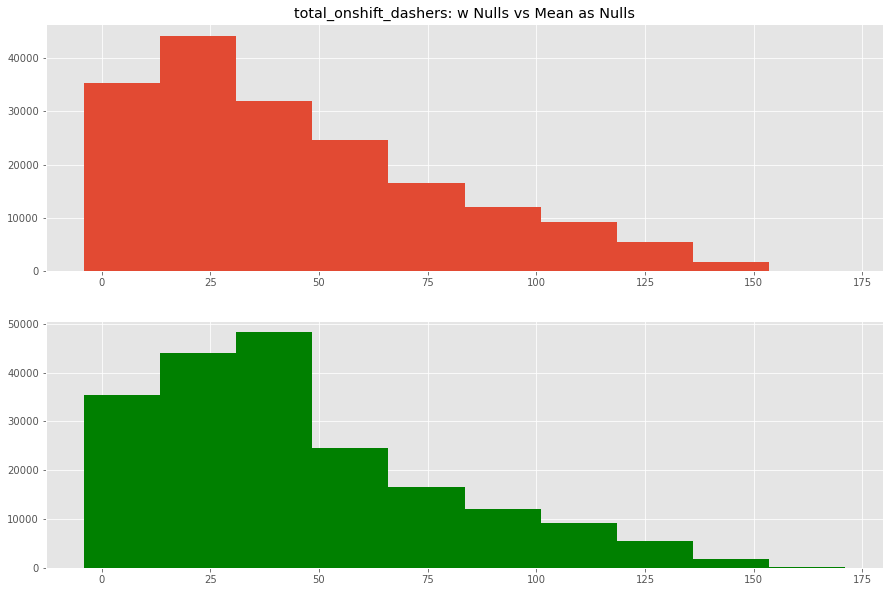

In [26]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('total_onshift_dashers: w Nulls vs Mean as Nulls')
df.total_onshift_dashers.hist();

plt.subplot(2,1,2)
df.total_onshift_dashers.fillna(df.total_onshift_dashers.mean()).hist(color='green')

plt.show();

In [28]:
df.total_onshift_dashers.describe()

count    181166.000000
mean         44.808093
std          34.526783
min          -4.000000
25%          17.000000
50%          37.000000
75%          65.000000
max         171.000000
Name: total_onshift_dashers, dtype: float64

In [29]:
(df.total_onshift_dashers.fillna(df.total_onshift_dashers.mean())).describe()

count    197428.000000
mean         44.808093
std          33.074249
min          -4.000000
25%          19.000000
50%          41.000000
75%          62.000000
max         171.000000
Name: total_onshift_dashers, dtype: float64

In [30]:
# filling NAs with mean
df.total_onshift_dashers = df.total_onshift_dashers.fillna(df.total_onshift_dashers.mean())

In [31]:
# checking
df.total_onshift_dashers.isnull().sum()

0

In [32]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
subtotal                                            0
total_onshift_dashers                               0
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
time                                                7
time_seconds                                        7
day_of_week                                         0
hour                                                0
rush_hour                                           0
dtype: int64

##### checking total_busy_dashers: if  filling mean in Nulls changes the distribution

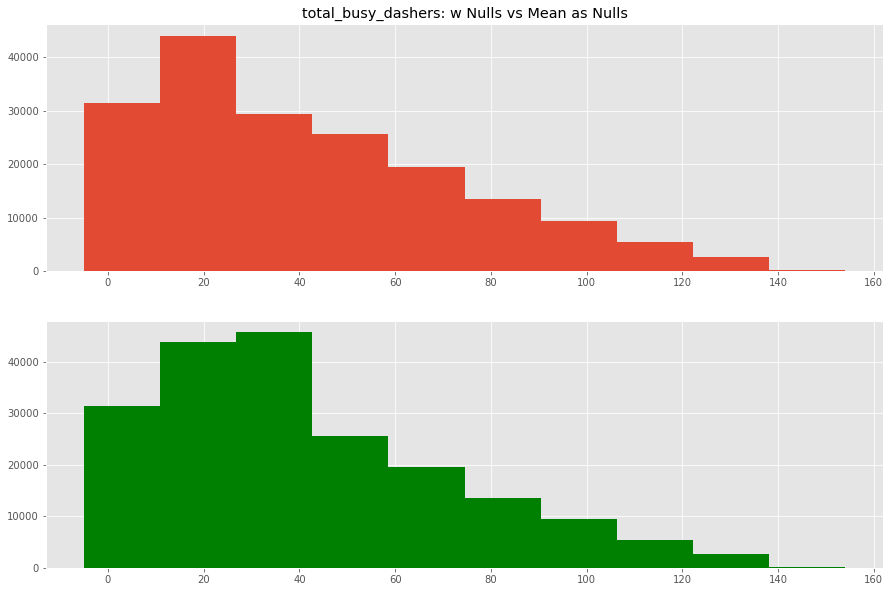

In [33]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('total_busy_dashers: w Nulls vs Mean as Nulls')
df.total_busy_dashers.hist();

plt.subplot(2,1,2)
df.total_busy_dashers.fillna(df.total_busy_dashers.mean()).hist(color='green')

plt.show();

In [34]:
df.total_busy_dashers.describe()

count    181166.000000
mean         41.739747
std          32.145733
min          -5.000000
25%          15.000000
50%          34.000000
75%          62.000000
max         154.000000
Name: total_busy_dashers, dtype: float64

In [35]:
df.total_busy_dashers.fillna(df.total_busy_dashers.mean()).describe()

count    197428.000000
mean         41.739747
std          30.793369
min          -5.000000
25%          17.000000
50%          39.000000
75%          59.000000
max         154.000000
Name: total_busy_dashers, dtype: float64

In [36]:
# filling NAs with mean
df.total_busy_dashers = df.total_busy_dashers.fillna(df.total_busy_dashers.mean())

In [37]:
# checking
df.total_busy_dashers.isnull().sum()

0

In [38]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
subtotal                                            0
total_onshift_dashers                               0
total_busy_dashers                                  0
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
time                                                7
time_seconds                                        7
day_of_week                                         0
hour                                                0
rush_hour                                           0
dtype: int64

##### checking total_outstanding_orders: if  filling mean in Nulls changes the distribution

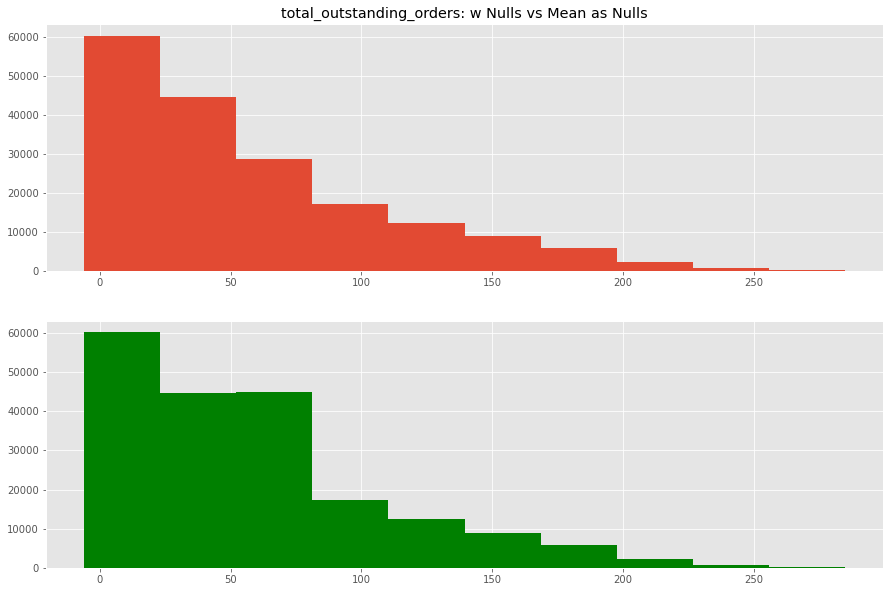

In [39]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('total_outstanding_orders: w Nulls vs Mean as Nulls')
df.total_outstanding_orders.hist();

plt.subplot(2,1,2)
df.total_outstanding_orders.fillna(df.total_outstanding_orders.mean()).hist(color='green')

plt.show();

In [40]:
df.total_outstanding_orders.describe()

count    181166.000000
mean         58.050065
std          52.661830
min          -6.000000
25%          17.000000
50%          41.000000
75%          85.000000
max         285.000000
Name: total_outstanding_orders, dtype: float64

In [41]:
df.total_outstanding_orders.fillna(df.total_outstanding_orders.mean()).describe()

count    197428.000000
mean         58.050065
std          50.446359
min          -6.000000
25%          19.000000
50%          47.000000
75%          80.000000
max         285.000000
Name: total_outstanding_orders, dtype: float64

In [42]:
# filling NAs with mean
df.total_outstanding_orders = df.total_outstanding_orders.fillna(df.total_outstanding_orders.mean())

In [43]:
# checking
df.total_outstanding_orders.isnull().sum()

0

In [44]:
df.isnull().sum()

market_id                                       987
created_at                                        0
actual_delivery_time                              7
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_store_to_consumer_driving_duration    526
time                                              7
time_seconds                                      7
day_of_week                                       0
hour                                              0
rush_hour                                         0
dtype: int64

##### checking estimated_store_to_consumer_driving_duration: if  filling mean in Nulls changes the distribution

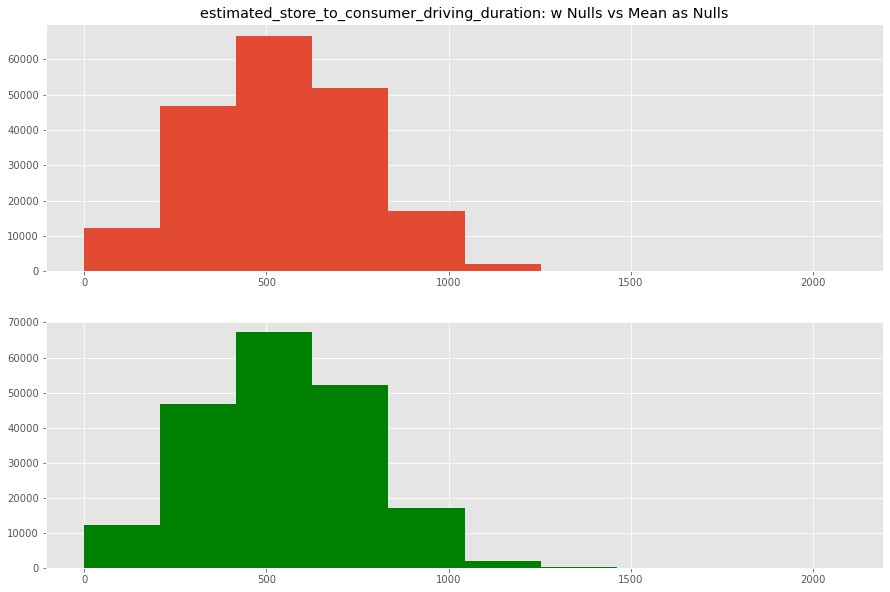

In [45]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.title('estimated_store_to_consumer_driving_duration: w Nulls vs Mean as Nulls')
df.estimated_store_to_consumer_driving_duration.hist();

plt.subplot(2,1,2)
df.estimated_store_to_consumer_driving_duration.fillna(df.estimated_store_to_consumer_driving_duration.mean()).hist(color='green')

plt.show();

In [46]:
df.estimated_store_to_consumer_driving_duration.describe()

count    196902.000000
mean        545.358935
std         219.352902
min           0.000000
25%         382.000000
50%         544.000000
75%         702.000000
max        2088.000000
Name: estimated_store_to_consumer_driving_duration, dtype: float64

In [47]:
df.estimated_store_to_consumer_driving_duration.fillna(df.total_outstanding_orders.mean()).describe()

count    197428.000000
mean        544.060616
std         220.496036
min           0.000000
25%         381.000000
50%         543.000000
75%         702.000000
max        2088.000000
Name: estimated_store_to_consumer_driving_duration, dtype: float64

In [48]:
# dropping out those data-samples given large data set
df = df[df.estimated_store_to_consumer_driving_duration.notnull()]
df.shape

(196902, 14)

In [49]:
df.isnull().sum()

market_id                                       986
created_at                                        0
actual_delivery_time                              7
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_store_to_consumer_driving_duration      0
time                                              7
time_seconds                                      7
day_of_week                                       0
hour                                              0
rush_hour                                         0
dtype: int64

#### *dropping rest giving small subset compare with size of DataFrame*

In [51]:
df = df.dropna()
df.isnull().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
subtotal                                        0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
time                                            0
time_seconds                                    0
day_of_week                                     0
hour                                            0
rush_hour                                       0
dtype: int64

In [232]:
df.shape

(195909, 14)

## 4. One-Hot Encoding for Categorical Variables

In [52]:
categorical = ['market_id','day_of_week','rush_hour']

In [53]:
df_cat = pd.DataFrame(index=df.index)

In [54]:
for col in categorical:
    df_cat = df_cat.join(pd.get_dummies(df[col],prefix=col,prefix_sep='_',drop_first=True) )

In [56]:
df_cat.head(3)

,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,rush_hour_1.0
0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0


In [57]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'subtotal', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'time', 'time_seconds',
       'day_of_week', 'hour', 'rush_hour'],
      dtype='object')

#### Numerical Variables

In [58]:
numerical = ['time_seconds', # diff btwn 'created_at' and 'actual_delivery_time'
             #'created_at'and'actual_delivery_time' won't be use given 'time_seconds' is used instead
             'subtotal', 
             'total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders',
             'estimated_store_to_consumer_driving_duration'
             ]

In [59]:
df_ = df[numerical].join(df_cat)

In [60]:
df_.head(2)

,time_seconds,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,rush_hour_1.0
0,3779.0,3441,33.0,14.0,21.0,861.0,0,0,0,0,0,0,0,0,1,0,0,0
1,4024.0,1900,1.0,2.0,2.0,690.0,1,0,0,0,0,1,0,0,0,0,0,0


In [61]:
y = df_[['time_seconds']]
y.head(3)

,time_seconds
0,3779.0
1,4024.0
2,1781.0


In [62]:
X = df_.drop(['time_seconds'],axis=1)
X.head(3)

,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,rush_hour_1.0
0,3441,33.0,14.0,21.0,861.0,0,0,0,0,0,0,0,0,1,0,0,0
1,1900,1.0,2.0,2.0,690.0,1,0,0,0,0,1,0,0,0,0,0,0
2,1900,1.0,0.0,0.0,690.0,0,1,0,0,0,0,0,1,0,0,0,0


In [64]:
(y.shape,X.shape)

((195909, 1), (195909, 17))

In [ ]:
(X.shape[1], )

In [ ]:
X[numerical[1:]].shape[1]

## 5. Outliers Research

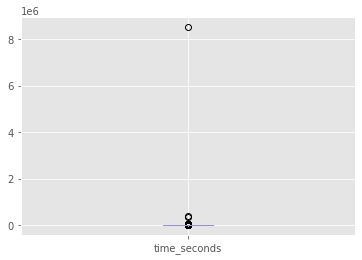

In [65]:
# box_plot of target variable
y.boxplot();

In [70]:
# list of extreme values of delivery time
y.sort_values(by=['time_seconds'],ascending=False)[:15]

,time_seconds
2690,8516859.0
185550,373879.0
27189,332482.0
83055,57032.0
190860,54447.0
86952,48178.0
76743,45685.0
105825,39352.0
66787,38457.0
175971,38143.0


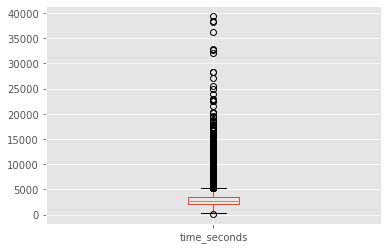

In [68]:
# how a boxplot of target variable would look like without extreme outliers
y.drop(y.sort_values(by=['time_seconds'],ascending=False).index[:7]).boxplot();

#### dropping extreme outliers

In [71]:
outliers = y.sort_values(by=['time_seconds'],ascending=False).index[:7]
outliers

Int64Index([2690, 185550, 27189, 83055, 190860, 86952, 76743], dtype='int64')

In [72]:
y = y.drop(outliers,axis=0)

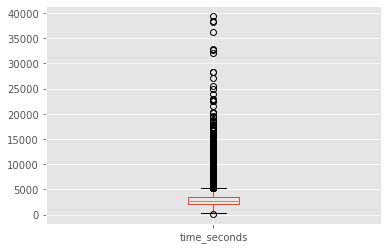

In [73]:
y.boxplot();

##### Assumption on non-extreme outliers
deliveries that lasted more than 30,000 seconds (8 hours) can be viewed as outliers. There were only 14. These will be removed

In [78]:
(y.time_seconds>30000).sum()

7

In [79]:
outliers_2 = y[y.time_seconds>30000].index

In [80]:
y = y.drop(outliers_2,axis=0)

In [74]:
X = X.drop(outliers,axis=0)

In [81]:
X = X.drop(outliers_2,axis=0)

In [82]:
(y.shape,X.shape)

((195895, 1), (195895, 17))

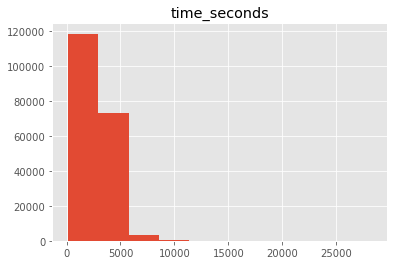

In [83]:
y.hist();

## 6. Train and Validation Sets

in order to assess predictability of unseen data, a validation subset is created in order to assess model's bias/vias with unseen data.

In [233]:
from sklearn.model_selection import train_test_split

In [234]:
X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=.85)

## 7. Scaling dataset 

training a machine learning model works best scaling the features and the target variables to show comparable proportionality deviations around their mean. The scaling applied here is a standardization, for numerical variables -not dummies.

In [84]:
import sklearn.preprocessing

In [85]:
from sklearn.preprocessing import StandardScaler

In [86]:
scaler = StandardScaler()

In [87]:
y_scaled = scaler.fit_transform(y)

In [235]:
y_train_scaled = scaler.fit_transform(y_train)

In [236]:
y_val_scaled = scaler.fit_transform(y_val)

In [237]:
pd.Series(y_scaled.reshape(-1)).describe()

count    1.958950e+05
mean     3.418758e-16
std      1.000003e+00
min     -2.448552e+00
25%     -6.708341e-01
50%     -1.773689e-01
75%      4.634259e-01
max      2.260102e+01
dtype: float64

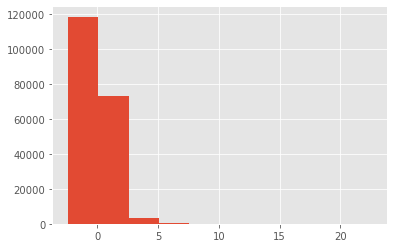

In [238]:
pd.Series(y_scaled.reshape(-1)).hist();

###### scaling only numerical features and not categorical dummies

In [239]:
# checking which features should be scaled
pd.Series(X.columns).T.head(6)

0                                        subtotal
1                           total_onshift_dashers
2                              total_busy_dashers
3                        total_outstanding_orders
4    estimated_store_to_consumer_driving_duration
5                                   market_id_2.0
dtype: object

In [88]:
X.columns[:5]

Index(['subtotal', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')

In [89]:
# Scaling Features (only numerical variables)
X_scaled = np.concatenate((scaler.fit_transform(X[ X.columns[:5] ]), # numerical features
               np.array(X[ X.columns[5:] ]) ), # categorical features
               axis=1)

In [90]:
X_scaled.shape

(195895, 17)

In [244]:
# Train set
X_train_scaled = np.concatenate((scaler.fit_transform(X_train[ X_train.columns[:5] ]), # numerical features
                                 np.array(X_train[ X_train.columns[5:] ]) ), # categorical features
                                axis=1)

In [245]:
# Validation set
X_val_scaled = np.concatenate((scaler.fit_transform(X_val[ X_val.columns[:5] ]), # numerical features
                               np.array(X_val[ X_val.columns[5:] ]) ), # categorical features
                              axis=1)

In [247]:
pd.DataFrame(X_scaled,columns=X.columns).describe()

,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,rush_hour_1.0
count,1.958950e+05,1.958950e+05,1.958950e+05,1.958950e+05,1.958950e+05,195895.000000,195895.000000,195895.000000,195895.000000,195895.000000,195895.000000,195895.000000,195895.000000,195895.000000,195895.000000,195895.00000,195895.000000
mean,2.109290e-16,-4.567718e-16,2.808192e-15,-1.989531e-15,1.552402e-16,0.280206,0.118640,0.242257,0.091661,0.073580,0.121999,0.122882,0.128155,0.141555,0.175487,0.17076,0.032288
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.449101,0.323365,0.428450,0.288548,0.261087,0.327286,0.328303,0.334264,0.348594,0.380384,0.37630,0.176764
min,-1.471862e+00,-1.475472e+00,-1.517685e+00,-1.269512e+00,-2.485988e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-7.038330e-01,-7.803347e-01,-8.035219e-01,-7.741152e-01,-7.444580e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,-2.649595e-01,-1.154211e-01,-8.935919e-02,-2.192708e-01,-5.903573e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,3.911564e-01,5.192691e-01,5.761106e-01,4.346531e-01,7.144150e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.339498e+01,3.813614e+00,3.643764e+00,4.496907e+00,7.033159e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


it can be seen numerical variables are standardized, having mean close to zero and std close to 1.

## 8. Neural Network Model

In [91]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

In [92]:
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [93]:
import tensorflow as tf
import keras.losses

In [348]:
# Type of Model
model = Sequential()

# Hidden Layer: 64 neurons
model.add( Dense(64, activation='relu',input_shape=(X_train_scaled.shape[1],) ) ) # input_dim=X.shape[1]
model.add(BatchNormalization())

model.add( Dense(32, activation='relu') )
model.add(BatchNormalization())

model.add( Dense(16, activation='relu') )
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer:
model.add( Dense(1, activation='linear'))

In [352]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                1152      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_14 (Batc (None, 16)                64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

*Note on model architecture:* 

There were several tries tunning manually tuning:
- the number of neurons
- number of hidden layers
- dropout rate for overfitting
- activation functions

final design is presented only for aesthetical purposes.

In [353]:
# Fitting
model.compile(loss='mse', optimizer='adam')

In [354]:
loss_fit = model.fit(X_train_scaled, y_train_scaled,
                     validation_data=(X_val_scaled,y_val_scaled),
                     batch_size=64, epochs=10, verbose=1);

Epoch 1/10
2602/2602 [==============================] - 9s 3ms/step - loss: 0.8305 - val_loss: 0.7713
Epoch 2/10
2602/2602 [==============================] - 9s 3ms/step - loss: 0.7551 - val_loss: 0.7672
Epoch 3/10
2602/2602 [==============================] - 8s 3ms/step - loss: 0.7497 - val_loss: 0.7636
Epoch 4/10
2602/2602 [==============================] - 8s 3ms/step - loss: 0.7464 - val_loss: 0.7567
Epoch 5/10
2602/2602 [==============================] - 9s 3ms/step - loss: 0.7448 - val_loss: 0.7583
Epoch 6/10
2602/2602 [==============================] - 8s 3ms/step - loss: 0.7430 - val_loss: 0.7575
Epoch 7/10
2602/2602 [==============================] - 8s 3ms/step - loss: 0.7409 - val_loss: 0.7540
Epoch 8/10
2602/2602 [==============================] - 8s 3ms/step - loss: 0.7402 - val_loss: 0.7573
Epoch 9/10
2602/2602 [==============================] - 8s 3ms/step - loss: 0.7409 - val_loss: 0.7559
Epoch 10/10
2602/2602 [==============================] - 8s 3ms/step - loss: 0.739

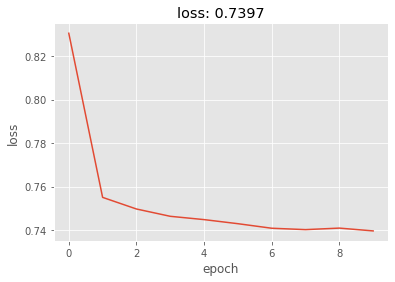

In [355]:
plt.plot(loss_fit.history['loss'])
plt.title('loss: ' + str(round(loss_fit.history['loss'][-1],4)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

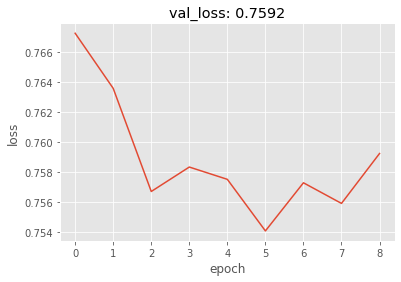

In [356]:
plt.plot(loss_fit.history['val_loss'][1:])
plt.title('val_loss: ' + str(round(loss_fit.history['val_loss'][-1],4)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [363]:
from sklearn.metrics import r2_score, mean_squared_error

In [357]:
# Prediction
y_train_pred_scaled = model.predict(X_train_scaled)
y_val_pred_scaled = model.predict(X_val_scaled)

In [358]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_train_pred = scaler.inverse_transform(y_train_pred_scaled)

In [359]:
# Scaling back to original units
y_val_scaled = scaler.fit_transform(y_val) # called again for reshaping scaler
y_val_pred = scaler.inverse_transform(y_val_pred_scaled)

In [ ]:
# Training Set Prediction df
df_train_pred = y_train.reset_index(drop=True).join(pd.DataFrame(y_train_pred,columns=['Prediction']))
df_train_pred.head(12)

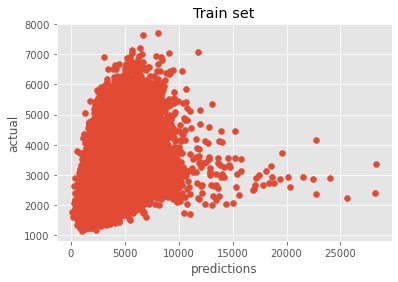

In [360]:
plt.scatter(y_train, y_train_pred)
plt.title('Train set')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.show()

In [361]:
print('R^2: '+str(r2_score(y_train, y_train_pred)) )

R^2: 0.27763288414023435


In [371]:
# Train RMSE:
rmse_train_nn = mean_squared_error(y_train, y_train_pred,squared=False).round(2)
print('Train RMSE: '+str(rmse_train_nn) )

Train RMSE: 955.18


In [366]:
'+/-'+str((mean_squared_error(y_train, y_train_pred,squared=False)/60).round(2))+' minutes off on average (Train set) '

'+/-15.92 minutes off on average (Train set) '

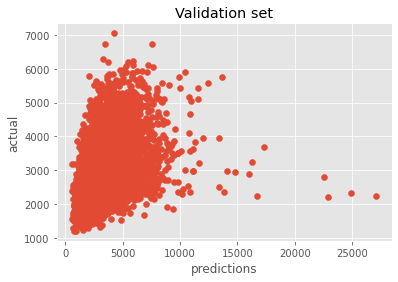

In [367]:
plt.scatter(y_val, y_val_pred)
plt.title('Validation set')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.show()

In [368]:
print('R^2: '+str(r2_score(y_val, y_val_pred)) )

R^2: 0.24078645040174784


In [370]:
# Validation RMSE
rmse_val_nn = mean_squared_error(y_val, y_val_pred,squared=False).round(2)
print('Validation RMSE: '+str(rmse_val_nn) )

Validation RMSE: 995.88


In [372]:
'+/-'+str((mean_squared_error(y_val, y_val_pred,squared=False)/60).round(2))+' minutes off on average (Validation set) '

'+/-16.6 minutes off on average (Validation set) '

## 8.b. LSTM Network

In [154]:
from keras.layers import LSTM

In [335]:
(X_train_scaled.shape,X_val_scaled.shape)

((166510, 17), (29385, 17))

In [336]:
# reshape input to be 3D [samples, timesteps, features]
X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_scaled_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled_3d = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
(X_train_scaled_3d.shape,X_val_scaled_3d.shape)

((166510, 1, 17), (29385, 1, 17))

In [337]:
# reshape input to be 3D [samples, timesteps, features]
y_scaled_3d = y_scaled[:,-1]
y_train_scaled_3d = y_train_scaled[:,-1]
y_val_scaled_3d = y_val_scaled[:,-1]
(y_train_scaled_3d.shape,y_val_scaled_3d.shape)

((166510,), (29385,))

In [338]:
# Type of Model
model = Sequential()

# Hidden Layer: 64 neurons
model.add( LSTM(64, activation='relu', #input_shape=(X_train_scaled.shape[1],) ) ) # input_dim=X.shape[1]
                input_shape=(X_train_scaled_3d.shape[1], 
                             X_train_scaled_3d.shape[2]) 
               )
         )
model.add(BatchNormalization())

model.add( Dense(32, activation='relu') )
model.add(BatchNormalization())

model.add( Dense(16, activation='relu') )
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer:
model.add( Dense(1, activation='linear'))

In [339]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                20992     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_11 (Batc (None, 16)                64        
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

*Note on model architecture:* 

There were several tries tunning manually tuning:
- the number of neurons
- number of hidden layers
- dropout rate for overfitting
- activation functions

final design is presented only for aesthetical purposes.

In [340]:
# Fitting
model.compile(loss='mse', optimizer='adam')

In [341]:
loss_fit = model.fit(X_train_scaled_3d, y_train_scaled_3d,
                     validation_data=(X_val_scaled_3d,y_val_scaled_3d),
                     batch_size=64, epochs=10, verbose=1);

Epoch 1/10
2602/2602 [==============================] - 17s 5ms/step - loss: 0.8756 - val_loss: 0.7727
Epoch 2/10
2602/2602 [==============================] - 12s 5ms/step - loss: 0.7555 - val_loss: 0.7598
Epoch 3/10
2602/2602 [==============================] - 12s 4ms/step - loss: 0.7499 - val_loss: 0.7619
Epoch 4/10
2602/2602 [==============================] - 12s 5ms/step - loss: 0.7469 - val_loss: 0.7566
Epoch 5/10
2602/2602 [==============================] - 12s 4ms/step - loss: 0.7439 - val_loss: 0.7541
Epoch 6/10
2602/2602 [==============================] - 12s 5ms/step - loss: 0.7424 - val_loss: 0.7623
Epoch 7/10
2602/2602 [==============================] - 12s 5ms/step - loss: 0.7416 - val_loss: 0.7589
Epoch 8/10
2602/2602 [==============================] - 12s 5ms/step - loss: 0.7399 - val_loss: 0.7570
Epoch 9/10
2602/2602 [==============================] - 11s 4ms/step - loss: 0.7392 - val_loss: 0.7499
Epoch 10/10
2602/2602 [==============================] - 12s 4ms/step - l

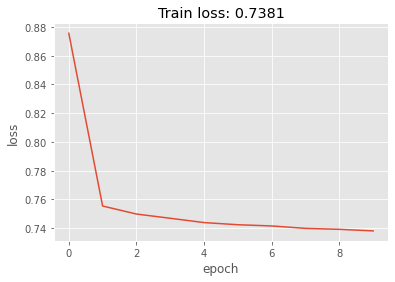

In [342]:
plt.plot(loss_fit.history['loss'])
plt.title('Train loss: ' + str(round(loss_fit.history['loss'][-1],4)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

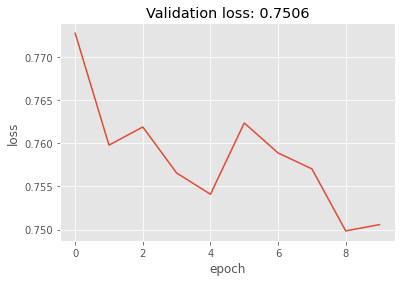

In [343]:
plt.plot(loss_fit.history['val_loss'])
plt.title('Validation loss: ' + str(round(loss_fit.history['val_loss'][-1],4)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [344]:
# Prediction
y_train_lstm_pred_scaled = model.predict(X_train_scaled_3d)
y_val_lstm_pred_scaled = model.predict(X_val_scaled_3d)

In [345]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_train_lstm_pred = scaler.inverse_transform(y_train_lstm_pred_scaled)
y_val_lstm_pred = scaler.inverse_transform(y_val_lstm_pred_scaled)

In [347]:
print('Train R^2: '+str(r2_score(y_train, y_train_lstm_pred).round(2)) )
print('val R^2: '+str(r2_score(y_val, y_val_lstm_pred).round(2)) )


Train R^2: 0.28
val R^2: 0.25


In [346]:
rmse_train_lstm = mean_squared_error(y_train, y_train_lstm_pred,squared=False).round(2)
print('Train RMSE: '+str(rmse_train_lstm) )

rmse_val_lstm = mean_squared_error(y_val, y_val_lstm_pred,squared=False).round(2)
print('val RMSE: '+str(rmse_val_lstm) )

Train RMSE: 956.11
val RMSE: 990.5


## 9.a. Decision Trees

In [139]:
from sklearn.tree import DecisionTreeRegressor

In [140]:
tree = DecisionTreeRegressor(criterion='mse',splitter='best',
                             min_samples_leaf=.1)

In [328]:
# Fit
tree.fit(X_train_scaled,y_train_scaled)

DecisionTreeRegressor(min_samples_leaf=0.1)

In [329]:
# Predict
y_tree_train_pred_scaled = tree.predict(X_train_scaled)
y_tree_val_pred_scaled   = tree.predict(X_val_scaled)

In [330]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_tree_train_pred = scaler.inverse_transform(y_tree_train_pred_scaled)
y_tree_val_pred = scaler.inverse_transform(y_tree_val_pred_scaled)

In [333]:
# Train RMSE in seconds:
rmse_train_tree = mean_squared_error(y_train, y_tree_train_pred,squared=False).round(2)
print('Train RMSE: '+str(rmse_train_tree))

Train RMSE: 1078.58


In [334]:
# Validation RMSE in seconds
rmse_val_tree =  mean_squared_error(y_val, y_tree_val_pred,squared=False).round(2)
print('Validation RMSE: '+str(rmse_val_tree) )

Validation RMSE: 1100.11


## 9.c. Bagging Regressor Tree

In [141]:
from sklearn.ensemble import BaggingRegressor

In [142]:
tree = DecisionTreeRegressor(criterion='mse',splitter='best',
                             min_samples_leaf=.1)

In [143]:
bc = BaggingRegressor(base_estimator=tree, n_estimators=100, n_jobs=-1)

In [319]:
# Fit
bc.fit(X_train_scaled,y_train_scaled)

C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


BaggingRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=0.1),
                 n_estimators=100, n_jobs=-1)

In [320]:
# Predict
y_bg_train_pred_scaled = bc.predict(X_train_scaled)
y_bg_val_pred_scaled   = bc.predict(X_val_scaled)

In [321]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_bg_train_pred = scaler.inverse_transform(y_bg_train_pred_scaled)
y_bg_val_pred = scaler.inverse_transform(y_bg_val_pred_scaled)

In [325]:
# Train scaled RMSE:
mean_squared_error(y_train_scaled, y_bg_train_pred_scaled,squared=False)

0.9618056895418153

In [323]:
# Train RMSE in seconds
rmse_train_bg = mean_squared_error(y_train, y_bg_train_pred,squared=False).round(2)
print('Train RMSE: '+str(rmse_train_bg))

Train RMSE: 1080.92


In [324]:
# Val scaled RMSE
mean_squared_error(y_val_scaled, y_bg_val_pred_scaled,squared=False)

0.9644804091170389

In [326]:
# Validation RMSE in seconds:
rmse_val_bg = mean_squared_error(y_val, y_bg_val_pred,squared=False).round(2)
print('Validation RMSE: '+str(rmse_val_bg))

Validation RMSE: 1102.43


## 9.c. Random Forest

In [144]:
from sklearn.ensemble import RandomForestRegressor

In [145]:
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=.1,n_jobs=-1)

In [306]:
# Fitting
rf.fit(X_train_scaled,y_train_scaled)

<ipython-input-306-67b1f8ba9479>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled,y_train_scaled)


RandomForestRegressor(min_samples_leaf=0.1, n_estimators=400, n_jobs=-1)

In [307]:
# Predict
y_rf_train_pred_scaled = rf.predict(X_train_scaled)
y_rf_val_pred_scaled   = rf.predict(X_val_scaled)

In [308]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_rf_train_pred = scaler.inverse_transform(y_rf_train_pred_scaled)
y_rf_val_pred = scaler.inverse_transform(y_rf_val_pred_scaled)

In [309]:
# Train scaled RMSE
mean_squared_error(y_train_scaled, y_rf_train_pred_scaled,squared=False)

0.9621652934671705

In [311]:
# Train RMSE in seconds
rmse_train_rf = mean_squared_error(y_train, y_rf_train_pred,squared=False).round(2)
print('Train RMSE: '+str(rmse_train_rf))

Train RMSE: 1081.32


In [316]:
# Val RMSE scaled
mean_squared_error(y_val_scaled, y_rf_val_pred_scaled,squared=False)

0.9648352567196502

In [318]:
# Val RMSE in seconds
rmse_val_rf = mean_squared_error(y_val, y_rf_val_pred,squared=False).round(2)
print('Val RMSE: '+str(rmse_val_rf))

Val RMSE: 1102.82


#### feature importance

In [ ]:
importances_rf = pd.Series(rf.feature_importances_, 
                           index = X.columns)

In [ ]:
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values(ascending=False)

In [ ]:
sorted_importances_rf[:5]

In [ ]:
# Make a horizontal bar plot
sorted_importances_rf[:5].plot(kind='barh', color='lightgreen',
                                title='Random Forest feature Importances') 
plt.show();

## 9.d. GradientBoosting

In [146]:
from sklearn.ensemble import GradientBoostingRegressor

In [147]:
gbt = GradientBoostingRegressor(n_estimators=400,min_samples_leaf=.1)

In [289]:
# Fitting
gbt.fit(X_train_scaled,y_train_scaled)

C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(criterion='mse', max_depth=6, max_features='sqrt',
                          min_samples_leaf=0.05, n_estimators=500)

In [290]:
# Predict
y_gbt_train_pred_scaled = gbt.predict(X_train_scaled)
y_gbt_val_pred_scaled   = gbt.predict(X_val_scaled)

In [291]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_gbt_train_pred = scaler.inverse_transform(y_gbt_train_pred_scaled)
y_gbt_val_pred = scaler.inverse_transform(y_gbt_val_pred_scaled)

In [299]:
# RMSE of scaled set
print('Train scaled RMSE: ' + str(mean_squared_error(y_train_scaled, y_gbt_train_pred_scaled,squared=False)))

Train scaled RMSE: 0.8571860102503688


In [312]:
# RMSE in seconds
rmse_train_gbt = mean_squared_error(y_train, y_gbt_train_pred,squared=False).round(2)
print('Train RMSE: ' + str(rmse_train_gbt))

Train RMSE: 963.34


In [301]:
# RMSE of scaled set
print('Validation scaled RMSE: ' + str(mean_squared_error(y_val_scaled, y_gbt_val_pred_scaled,squared=False)))

Validation scaled RMSE: 0.8761546522526673


In [313]:
# RMSE in seconds
rmse_val_gbt = mean_squared_error(y_val, y_gbt_val_pred,squared=False).round(2)
print('Validation RMSE: ' + str(rmse_val_gbt))

Validation RMSE: 1001.24


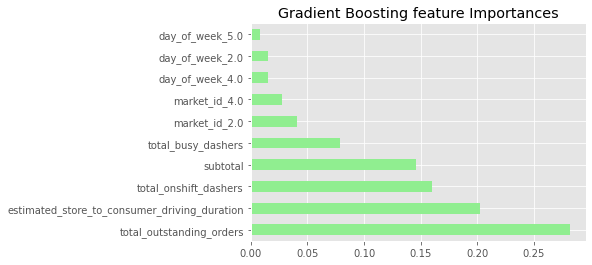

In [296]:
# Sort importances
importances_gbt = pd.Series(gbt.feature_importances_,index = X.columns)
sorted_importances_gbt = importances_gbt.sort_values(ascending=False)

# Make a horizontal bar plot
sorted_importances_gbt[:10].plot(kind='barh', color='lightgreen',
                                title='Gradient Boosting feature Importances') 
plt.show();

given impurity-based Gini importance, **total_outstanding_orders** and **estimated_store_to_consumer_driving_duration** features seem to be the most influencing variables in a Gradient Boosting Model.

## 10.a. Regularized Regression: Lasso

In [131]:
from sklearn.linear_model import Lasso, Ridge

In [251]:
from sklearn.model_selection import GridSearchCV

##### GridSearch & CV

In [132]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [249]:
lasso = Lasso()

In [256]:
params_lasso = {'alpha': [1,.5,.05]}

In [257]:
grid_lasso = GridSearchCV(estimator=lasso,
                        param_grid=params_lasso,
                        cv=4,
                        scoring='neg_mean_squared_error',
                        verbose=1,
                        n_jobs=-1)

In [258]:
grid_lasso.fit(X_train_scaled,y_train_scaled)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.6s finished


GridSearchCV(cv=4, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1, 0.5, 0.05]},
             scoring='neg_mean_squared_error', verbose=1)

In [259]:
# Extract the best hyperparameters from GridSeach
print('Best hyperparameters:\n', grid_lasso.best_params_)

Best hyperparameters:
 {'alpha': 0.05}


In [262]:
# Training
lasso_fit = grid_lasso.best_estimator_.fit(X_train_scaled,y_train_scaled)

In [263]:
# Feature Selection
lasso_coef = lasso_fit.coef_
lasso_coef_df = pd.Series(lasso_coef,index=X.columns)
lasso_coef_df.sort_values(ascending=False).head(6)

estimated_store_to_consumer_driving_duration    0.172687
subtotal                                        0.145458
total_outstanding_orders                        0.103146
day_of_week_6.0                                 0.000000
total_busy_dashers                             -0.000000
market_id_2.0                                  -0.000000
dtype: float64

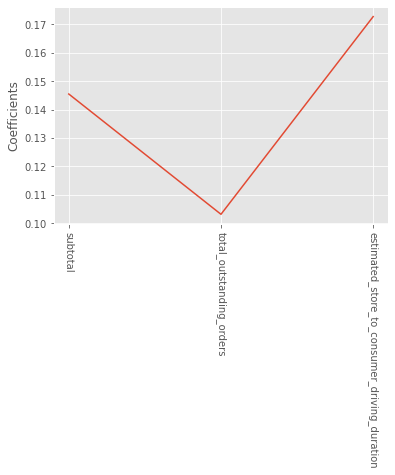

In [266]:
lasso_coef_ = lasso_coef_df[lasso_coef_df>0]
_ = plt.plot(range(len(lasso_coef_.index)), lasso_coef_)
_ = plt.xticks(range(len(lasso_coef_.index)), lasso_coef_.index, rotation=270)
_ = plt.ylabel('Coefficients')
plt.show()

similarly to the Gradient Boosting model results previously, **total_outstanding_orders** and **estimated_store_to_consumer_driving_duration** features seem to be  influencing variables in a Reguralized L1-Norm Model.

In [267]:
# Predict
y_lasso_train_pred_scaled = grid_lasso.best_estimator_.predict(X_train_scaled)
y_lasso_val_pred_scaled = grid_lasso.best_estimator_.predict(X_val_scaled)

In [273]:
# RMSE of scaled data
print('Train Scale RMSE: ' + str(mean_squared_error(y_train_scaled, 
                                              y_lasso_train_pred_scaled,
                                              squared=False).round(4) ) )
print('Validation Scale RMSE: ' + str(mean_squared_error(y_val_scaled, 
                                                   y_lasso_val_pred_scaled,
                                                   squared=False).round(4) ) )

Train Scale RMSE: 0.9434
Validation Scale RMSE: 0.9491


In [271]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_lasso_train_pred = scaler.inverse_transform(y_lasso_train_pred_scaled)
y_lasso_val_pred = scaler.inverse_transform(y_lasso_val_pred_scaled)

In [315]:
# RMSE in seconds
rmse_train_lasso = mean_squared_error(y_train,y_lasso_train_pred,squared=False).round(2)
print('Train RMSE: ' + str(rmse_train_lasso ) )

rmse_val_lasso = mean_squared_error(y_val,y_lasso_val_pred,squared=False).round(2)
print('Validation RMSE: ' + str(rmse_val_lasso) ) 

Train RMSE: 1060.24
Validation RMSE: 1085.05


## 10.b. Ridge

In [148]:
Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

#### GridSearch & CV

In [274]:
params_ridge = {'alpha': [.5,.05,-.05,-.5]}

In [275]:
ridge_gs = Ridge()

In [276]:
grid_ridge = GridSearchCV(estimator=ridge_gs,
                          param_grid = params_ridge,
                          cv = 2,
                          scoring='neg_mean_squared_error',
                          verbose=1,
                          n_jobs=-1)

In [277]:
grid_ridge.fit(X_train_scaled,y_train_scaled)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.1s finished


GridSearchCV(cv=2, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.5, 0.05, -0.05, -0.5]},
             scoring='neg_mean_squared_error', verbose=1)

In [278]:
# Extract the best hyperparameters from GridSeach
print('Best hyperparameters:\n', grid_ridge.best_params_)

Best hyperparameters:
 {'alpha': 0.5}


In [279]:
ridge = Ridge(alpha=.05,fit_intercept=False)

In [280]:
ridge_fit = ridge.fit(X_train_scaled,y_train_scaled)

In [281]:
# Predicting
y_ridge_train_pred_scaled = ridge_fit.predict(X_train_scaled)
y_ridge_val_pred_scaled   = ridge_fit.predict(X_val_scaled)

In [283]:
# RMSE of Scaled data
print('Train Scale RMSE: ' + str(mean_squared_error(y_train_scaled, 
                                              y_ridge_train_pred_scaled,
                                              squared=False).round(4) ) )
print('Validation Scale RMSE: ' + str(mean_squared_error(y_val_scaled, 
                                                   y_ridge_val_pred_scaled,
                                                   squared=False).round(4) ) )

Train Scale RMSE: 0.8901
Validation Scale RMSE: 0.9034


In [284]:
# Scaling back to original units
y_train_scaled = scaler.fit_transform(y_train) # called again for reshaping scaler
y_ridge_train_pred = scaler.inverse_transform(y_ridge_train_pred_scaled)
y_ridge_val_pred = scaler.inverse_transform(y_ridge_val_pred_scaled)

In [375]:
# RMSE in seconds
rmse_train_ridge = mean_squared_error(y_train,y_ridge_train_pred,squared=False).round(2)
print('Train RMSE: ' + str(rmse_train_ridge) )

rmse_val_ridge = mean_squared_error(y_val,y_ridge_val_pred,squared=False).round(2)
print('Validation RMSE: ' + str(rmse_val_ridge) )

Train RMSE: 1000.28
Validation RMSE: 1032.44


## 11. Summary of Models and full re-training

In [386]:
rmse_names = ['rmse_nn','rmse_lstm','rmse_tree','rmse_bg','rmse_rf','rmse_gbt','rmse_lasso', 'rmse_ridge']

In [387]:
rmse_train_values = [rmse_train_nn,rmse_train_lstm,
                   rmse_train_tree,rmse_train_bg,rmse_train_rf, rmse_train_gbt,
                   rmse_train_lasso, rmse_train_ridge]

In [388]:
rmse_val_values = [rmse_val_nn,rmse_val_lstm,
                   rmse_val_tree,rmse_val_bg,rmse_val_rf, rmse_val_gbt,
                   rmse_val_lasso, rmse_val_ridge]

In [394]:
summary_results = pd.DataFrame(rmse_train_values,
                               index=rmse_names,
                               columns=['Train'])
summary_results = summary_results.join(\
                                       pd.DataFrame(rmse_val_values,
                                                    index=rmse_names,
                                                    columns=['Validation']))
summary_results

,Train,Validation
rmse_nn,955.18,995.88
rmse_lstm,956.11,990.50
rmse_tree,1078.58,1100.11
rmse_bg,1080.92,1102.43
rmse_rf,1081.32,1102.82
rmse_gbt,963.34,1001.24
rmse_lasso,1060.24,1085.05
rmse_ridge,1000.28,1032.44


In [395]:
summary_results.sort_values(by='Validation',ascending=True)

,Train,Validation
rmse_lstm,956.11,990.50
rmse_nn,955.18,995.88
rmse_gbt,963.34,1001.24
rmse_ridge,1000.28,1032.44
rmse_lasso,1060.24,1085.05
rmse_tree,1078.58,1100.11
rmse_bg,1080.92,1102.43
rmse_rf,1081.32,1102.82


In [396]:
summary_results.describe()

,Train,Validation
count,8.000000,8.000000
mean,1021.996250,1051.308750
std,59.007483,51.297152
min,955.180000,990.500000
25%,961.532500,999.900000
50%,1030.260000,1058.745000
75%,1079.165000,1100.690000
max,1081.320000,1102.820000


**The loss function used (root-mean-squared-error) shows that most models have similar results, with slightly higher rmse for the validation set (showing no overfitting) and  similar rmse (average) and similarly dispersed (std) between Train and Val set.**

a full training will be used before predicting unseen data.

##### Lasso

In [287]:
lasso_fit = lasso.fit(X_scaled,y_scaled)

##### Ridge

In [286]:
ridge_fit = ridge.fit(X_scaled,y_scaled)

##### Decission Tree

In [149]:
tree = DecisionTreeRegressor(criterion='mse',splitter='best',min_samples_leaf=.1)
tree_fit = tree.fit(X_scaled,y_scaled)

##### Bagging Regressor

In [150]:
bc = BaggingRegressor(base_estimator=tree, n_estimators=100, n_jobs=-1)
bc_fit = bc.fit(X_scaled,y_scaled)

C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


##### Gradient Boosting

In [151]:
gbt = GradientBoostingRegressor(criterion='mse', max_depth= 6, max_features='sqrt',
                                min_samples_leaf= 0.05, n_estimators= 500)
gbt_fit = gbt.fit(X_scaled,y_scaled)

C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


##### Deep Neural Network

In [152]:
# 2-hidden layers NN
nn_model = Sequential()

nn_model.add( Dense(64, activation='relu',input_shape=(X_scaled.shape[1],) ) ) # input_dim=X.shape[1]
nn_model.add(BatchNormalization())

nn_model.add( Dense(32, activation='relu') )
nn_model.add(BatchNormalization())

nn_model.add( Dense(16, activation='relu') )
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.2))

nn_model.add( Dense(1, activation='linear'))

# Defining Loss function and Optimizer
nn_model.compile(loss='mse', optimizer='adam')  
# Fitting
nn_model_fit = nn_model.fit(X_scaled, y_scaled,batch_size=64, epochs=200, verbose=1);

Epoch 1/200
3061/3061 [==============================] - 11s 3ms/step - loss: 0.8639
Epoch 2/200
3061/3061 [==============================] - 8s 2ms/step - loss: 0.7560
Epoch 3/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7515
Epoch 4/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7489
Epoch 5/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7471
Epoch 6/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7459
Epoch 7/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7455
Epoch 8/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7441
Epoch 9/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7435
Epoch 10/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7420
Epoch 11/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7415
Epoch 12/200
3061/3061 [==============================] - 8s 3ms/step - l

3061/3061 [==============================] - 7s 2ms/step - loss: 0.7221
Epoch 193/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7231
Epoch 194/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7230
Epoch 195/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7228
Epoch 196/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7227
Epoch 197/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7227
Epoch 198/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7231
Epoch 199/200
3061/3061 [==============================] - 8s 2ms/step - loss: 0.7214
Epoch 200/200
3061/3061 [==============================] - 8s 3ms/step - loss: 0.7226


##### LSTM NN

In [156]:
# reshape input to be 3D [samples, timesteps, features]
X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_scaled_3d = y_scaled.reshape((y_scaled.shape[0], 1, y_scaled.shape[1]))

# 2-hidden layer lstm_model
lstm_model = Sequential()
lstm_model.add( LSTM(64, activation='relu', 
                     input_shape=(X_scaled_3d.shape[1], X_scaled_3d.shape[2])))
lstm_model.add(BatchNormalization())

lstm_model.add( Dense(32, activation='relu') )
lstm_model.add(BatchNormalization())

lstm_model.add( Dense(16, activation='relu') )
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))

# Output Layer:
lstm_model.add( Dense(1, activation='linear'))

# Defining Loss function and Optimizer
lstm_model.compile(loss='mse',optimizer='adam')  
# Fitting
lstm_model_fit = lstm_model.fit(X_scaled_3d, y_scaled_3d,batch_size=64, epochs=200, verbose=1);

Epoch 1/200
3061/3061 [==============================] - 16s 4ms/step - loss: 0.8393
Epoch 2/200
3061/3061 [==============================] - 13s 4ms/step - loss: 0.7560
Epoch 3/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7501
Epoch 4/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7485
Epoch 5/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7463
Epoch 6/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7449
Epoch 7/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7426
Epoch 8/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7427
Epoch 9/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7416
Epoch 10/200
3061/3061 [==============================] - 13s 4ms/step - loss: 0.7405
Epoch 11/200
3061/3061 [==============================] - 13s 4ms/step - loss: 0.7410
Epoch 12/200
3061/3061 [==============================] - 12s 4

3061/3061 [==============================] - 12s 4ms/step - loss: 0.7120
Epoch 191/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7117
Epoch 192/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7122
Epoch 193/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7124
Epoch 194/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7127
Epoch 195/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7124
Epoch 196/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7117
Epoch 197/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7123
Epoch 198/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7111
Epoch 199/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7123
Epoch 200/200
3061/3061 [==============================] - 12s 4ms/step - loss: 0.7113


## 12. Pre-processing Predict dataset (Test)

In [94]:
test.shape

(54778, 9)

In [95]:
# Day of the Week
for i in test.index:
    test.loc[i,'day_of_week'] = test.created_at[i].weekday()

In [96]:
# Hour
for i in test.index:
    test.loc[i,'hour'] = test.created_at[i].hour

In [97]:
# RushHour
for i in test.index:
    if (test.loc[i,'day_of_week'] < 5) and ( (test.loc[i,'hour'] >= 16.) and (test.loc[i,'hour'] < 19.) ):
        test.loc[i,'rush_hour'] = 1
    else:
        test.loc[i,'rush_hour'] = 0

In [98]:
# Missing Values
test.isnull().sum()

market_id                                        250
created_at                                         0
store_id                                           0
subtotal                                           0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
day_of_week                                        0
hour                                               0
rush_hour                                          0
dtype: int64

the assumption to fill NAs with mean is based on the analysis done above where it was shown that *total_onshift_dashers*, *total_busy_dashers*  and *total_outstanding_orders*, *estimated_store_to_consumer_driving_duration* seem to have semi-normal distribution.

Dropping them out implies around ~8.5% of the whole test data not being forecasted.

The need to assume Train_average of these features is because all models (except for lasso) need all features in order to predict

In [99]:
# filling NAs with Train (i.e. seen) mean
test.total_onshift_dashers = test.total_onshift_dashers.fillna(df.total_onshift_dashers.mean())

test.total_busy_dashers = test.total_busy_dashers.fillna(df.total_busy_dashers.mean())

test.total_outstanding_orders = test.total_outstanding_orders.fillna(df.total_outstanding_orders.mean())

test.estimated_store_to_consumer_driving_duration = test.estimated_store_to_consumer_driving_duration.fillna(df.estimated_store_to_consumer_driving_duration.mean())

In [100]:
test.shape

(54778, 12)

In [101]:
test.isnull().sum()

market_id                                       250
created_at                                        0
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_store_to_consumer_driving_duration      0
delivery_id                                       0
day_of_week                                       0
hour                                              0
rush_hour                                         0
dtype: int64

#### *market_id* missing values will be assumed to be 'market_id = = 1'. 
This is an oversimplification just to not dismiss any prediction.

If these predictions are off, they only represent 0.5% on the whole Test set

A more thorough approach would be to have a model that predicts (with a certain degree of probability) which market_id represents given similarities on the other features in the Train set (i.e. Clustering analysis).



In [107]:
# indicies where market_id has NaN
indicies = test[test.market_id.isna()]['market_id'].index[:3]
indicies

Int64Index([540, 585, 1003], dtype='int64')

In [124]:
# filling market_id NAs with 1 -> this will assume it is market_id = 1
test = test.fillna(1)

In [168]:
test.shape

(54778, 17)

In [126]:
# check
test.loc[indicies,:]

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,day_of_week,hour,rush_hour
540,0.0,2015-02-22 01:32:11,3243,9300,44.0,44.0,36.0,451.0,77554,6.0,1.0,0.0
585,0.0,2015-02-22 23:31:56,5589,4890,11.0,11.0,9.0,323.0,98193,6.0,23.0,0.0
1003,0.0,2015-02-21 23:15:21,6252,890,29.0,28.0,43.0,199.0,79954,5.0,23.0,0.0


In [127]:
# one-hot encoding categorical variables
categorical = ['market_id','day_of_week','rush_hour']
test_cat = pd.DataFrame(index=test.index)
for col in categorical:
    test_cat = test_cat.join(pd.get_dummies(test[col],
                                                prefix=col,
                                                prefix_sep='_',
                                                drop_first=True) )
test_cat.head(1)

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,rush_hour_1.0
0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [128]:
# join with numerical variables
numerical = ['subtotal', 'total_onshift_dashers',
             'total_busy_dashers','total_outstanding_orders',
             'estimated_store_to_consumer_driving_duration']

test = test[numerical].join(test_cat)

Reminder: *'created_at'* is not used since it 'day_of_week', 'hour' and categorical  'rush_hour' extracts same information from it 

In [169]:
X_test = test

In [170]:
# Scaling Features (only numerical variables)
X_test_scaled = np.concatenate(
    (scaler.fit_transform(X_test[ X_test.columns[:5] ]), # numerical features
               np.array(X_test[ X_test.columns[5:] ]) ), # categorical features
    axis=1)

## 13. Predicting on Test set

In [173]:
y_lasso_pred_scaled = lasso_fit.predict(X_test_scaled)

In [174]:
y_ridge_pred_scaled = ridge_fit.predict(X_test_scaled)

In [175]:
y_tree_pred_scaled = tree_fit.predict(X_test_scaled)

In [176]:
y_bc_pred_scaled = bc_fit.predict(X_test_scaled)

In [177]:
y_gbt_pred_scaled = gbt_fit.predict(X_test_scaled)

In [178]:
y_nn_pred_scaled = nn_model.predict(X_test_scaled)

In [179]:
# LSTM
# reshape test set to 3D
X_test_scaled_3d = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

y_lstm_pred_scaled = lstm_model.predict(X_test_scaled_3d)

In [180]:
# Scaling back to original units

# called again for reshaping scaler
_scaled = scaler.fit_transform(np.array(X_test.iloc[:,0]).reshape(-1,1)) 

y_lasso_pred = scaler.inverse_transform(y_lasso_pred_scaled)
y_ridge_pred = scaler.inverse_transform(y_ridge_pred_scaled)
y_tree_pred = scaler.inverse_transform(y_tree_pred_scaled)
y_bc_pred = scaler.inverse_transform(y_bc_pred_scaled)
y_gbt_pred = scaler.inverse_transform(y_gbt_pred_scaled)
y_nn_pred = scaler.inverse_transform(y_nn_pred_scaled)
y_lstm_pred = scaler.inverse_transform(y_lstm_pred_scaled)

#### adding predictions to predict dataset

In [185]:
test.columns

Index(['subtotal', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'day_of_week_1.0', 'day_of_week_2.0', 'day_of_week_3.0',
       'day_of_week_4.0', 'day_of_week_5.0', 'day_of_week_6.0',
       'rush_hour_1.0'],
      dtype='object')

In [187]:
# bringing back 'created_at'
created_at = pd.read_csv('predict_data.csv', parse_dates=['created_at'])[['created_at']]
created_at.head(2)

,created_at
0,2015-02-25 02:22:30
1,2015-02-25 01:14:19


In [189]:
test = test.join(created_at,how='left')

In [190]:
# prediction for Lasso
for i in test.index:
    test.loc[i,'lasso_pred'] = test.loc[i,'created_at'] + \
    datetime.timedelta(seconds=pd.Series(y_lasso_pred.round(0),
                                         index=test.index).loc[i]
                      )

In [191]:
test[['created_at','lasso_pred']].head()

,created_at,lasso_pred
0,2015-02-25 02:22:30,2015-02-25 03:18:56
1,2015-02-25 01:14:19,2015-02-25 02:04:06
2,2015-02-22 02:27:44,2015-02-22 03:13:00
3,2015-02-25 01:32:39,2015-02-25 02:15:33
4,2015-02-24 05:20:45,2015-02-24 06:03:16


In [192]:
# prediction for Ridge Regression
for i in test.index:
    test.loc[i,'ridge_pred'] = test.loc[i,'created_at'] + \
    datetime.timedelta(seconds=pd.Series(y_ridge_pred.reshape(-1).round(0),
                                         index=test.index).loc[i]
                      )

In [193]:
test[['created_at','ridge_pred']].head()

,created_at,ridge_pred
0,2015-02-25 02:22:30,2015-02-25 03:26:34
1,2015-02-25 01:14:19,2015-02-25 02:08:46
2,2015-02-22 02:27:44,2015-02-22 03:14:02
3,2015-02-25 01:32:39,2015-02-25 02:19:15
4,2015-02-24 05:20:45,2015-02-24 06:08:11


In [194]:
# prediction for Decission Tree
for i in test.index:
    test.loc[i,'tree_pred'] = test.loc[i,'created_at'] + \
    datetime.timedelta(seconds=pd.Series(y_tree_pred.reshape(-1).round(0),
                                         index=test.index).loc[i]
                      )

In [195]:
test[['created_at','tree_pred']].head()

,created_at,tree_pred
0,2015-02-25 02:22:30,2015-02-25 03:21:48
1,2015-02-25 01:14:19,2015-02-25 02:00:34
2,2015-02-22 02:27:44,2015-02-22 03:13:59
3,2015-02-25 01:32:39,2015-02-25 02:22:57
4,2015-02-24 05:20:45,2015-02-24 06:11:03


In [196]:
# prediction for Bagging Regressor
for i in test.index:
    test.loc[i,'bc_pred'] = test.loc[i,'created_at'] + \
    datetime.timedelta(seconds=pd.Series(y_bc_pred.reshape(-1).round(0),
                                         index=test.index).loc[i]
                      )

In [197]:
test[['created_at','bc_pred']].head()

,created_at,bc_pred
0,2015-02-25 02:22:30,2015-02-25 03:21:15
1,2015-02-25 01:14:19,2015-02-25 02:00:26
2,2015-02-22 02:27:44,2015-02-22 03:15:25
3,2015-02-25 01:32:39,2015-02-25 02:17:57
4,2015-02-24 05:20:45,2015-02-24 06:07:36


In [198]:
# prediction for Gradient Boosting
for i in test.index:
    test.loc[i,'gbt_pred'] = test.loc[i,'created_at'] + \
    datetime.timedelta(seconds=pd.Series(y_gbt_pred.reshape(-1).round(0),
                                         index=test.index).loc[i]
                      )

In [199]:
test[['created_at','gbt_pred']].head()

,created_at,gbt_pred
0,2015-02-25 02:22:30,2015-02-25 03:35:54
1,2015-02-25 01:14:19,2015-02-25 02:13:56
2,2015-02-22 02:27:44,2015-02-22 03:11:59
3,2015-02-25 01:32:39,2015-02-25 02:25:49
4,2015-02-24 05:20:45,2015-02-24 06:24:18


In [201]:
# prediction for Neural Network
for i in test.index:
    test.loc[i,'nn_model_pred'] = test.loc[i,'created_at'] + \
    datetime.timedelta(seconds=pd.Series(y_nn_pred.reshape(-1).astype('float64').round(0),
                                         index=test.index).loc[i]
                      )

In [202]:
test[['created_at','nn_model_pred']].head()

,created_at,nn_model_pred
0,2015-02-25 02:22:30,2015-02-25 03:24:56
1,2015-02-25 01:14:19,2015-02-25 02:01:35
2,2015-02-22 02:27:44,2015-02-22 03:13:43
3,2015-02-25 01:32:39,2015-02-25 02:31:09
4,2015-02-24 05:20:45,2015-02-24 06:21:30


In [203]:
# prediction LSTM Neural Network
for i in test.index:
    test.loc[i,'lstm_model_pred'] = test.loc[i,'created_at'] + \
    datetime.timedelta(seconds=pd.Series(y_lstm_pred.reshape(-1).astype('float64').round(0),
                                         index=test.index).loc[i]
                      )

In [204]:
test[['created_at','lstm_model_pred']].head()

,created_at,lstm_model_pred
0,2015-02-25 02:22:30,2015-02-25 03:20:18
1,2015-02-25 01:14:19,2015-02-25 01:48:58
2,2015-02-22 02:27:44,2015-02-22 03:16:09
3,2015-02-25 01:32:39,2015-02-25 02:27:32
4,2015-02-24 05:20:45,2015-02-24 06:09:27


In [231]:
# all predictions
test[['created_at','lasso_pred','ridge_pred', 'tree_pred', 'bc_pred', 'gbt_pred','nn_model_pred','lstm_model_pred']]

,created_at,lasso_pred,ridge_pred,tree_pred,bc_pred,gbt_pred,nn_model_pred,lstm_model_pred
0,2015-02-25 02:22:30,2015-02-25 03:18:56,2015-02-25 03:26:34,2015-02-25 03:21:48,2015-02-25 03:21:15,2015-02-25 03:35:54,2015-02-25 03:24:56,2015-02-25 03:20:18
1,2015-02-25 01:14:19,2015-02-25 02:04:06,2015-02-25 02:08:46,2015-02-25 02:00:34,2015-02-25 02:00:26,2015-02-25 02:13:56,2015-02-25 02:01:35,2015-02-25 01:48:58
2,2015-02-22 02:27:44,2015-02-22 03:13:00,2015-02-22 03:14:02,2015-02-22 03:13:59,2015-02-22 03:15:25,2015-02-22 03:11:59,2015-02-22 03:13:43,2015-02-22 03:16:09
3,2015-02-25 01:32:39,2015-02-25 02:15:33,2015-02-25 02:19:15,2015-02-25 02:22:57,2015-02-25 02:17:57,2015-02-25 02:25:49,2015-02-25 02:31:09,2015-02-25 02:27:32
4,2015-02-24 05:20:45,2015-02-24 06:03:16,2015-02-24 06:08:11,2015-02-24 06:11:03,2015-02-24 06:07:36,2015-02-24 06:24:18,2015-02-24 06:21:30,2015-02-24 06:09:27
...,...,...,...,...,...,...,...,...
54773,2015-02-20 18:11:18,2015-02-20 18:56:34,2015-02-20 18:56:56,2015-02-20 19:01:36,2015-02-20 19:01:48,2015-02-20 18:57:56,2015-02-20 18:50:42,2015-02-20 18:51:10
54774,2015-02-21 21:01:44,2015-02-21 21:41:25,2015-02-21 21:44:35,2015-02-21 21:33:53,2015-02-21 21:37:44,2015-02-21 21:50:04,2015-02-21 21:46:09,2015-02-21 21:46:22
54775,2015-02-21 18:19:19,2015-02-21 18:56:36,2015-02-21 19:01:21,2015-02-21 19:05:34,2015-02-21 19:04:30,2015-02-21 19:07:57,2015-02-21 19:02:53,2015-02-21 19:03:18
54776,2015-02-19 23:43:26,2015-02-20 00:24:15,2015-02-20 00:30:49,2015-02-20 00:33:44,2015-02-20 00:28:02,2015-02-20 00:46:14,2015-02-20 00:51:36,2015-02-20 00:50:49


## 14. Exporting Predictions

In [229]:
test.to_csv('predict_data_results.csv',index=True)